# Oil Price Stationarity & Autocorrelation

In [34]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import random
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')

In [35]:
from kagglehub import KaggleDatasetAdapter

# Load the latest version
df = pd.read_csv("./datasets/commodity_prices.csv")

df.drop(columns=["Unnamed: 0"], inplace=True)

df.head()

,date,oil_brent,oil_dubai,coffee_arabica,coffee_robustas,tea_columbo,tea_kolkata,tea_mombasa,sugar_eu,sugar_us,sugar_world
0,1960-01-01,1.63,1.63,0.9409,0.696864,0.930301,1.121401,1.0374,0.122356,0.116845,0.0666
1,1960-02-01,1.63,1.63,0.9469,0.688707,0.930301,1.121401,1.0374,0.122356,0.119049,0.0679
2,1960-03-01,1.63,1.63,0.9281,0.688707,0.930301,1.121401,1.0374,0.122356,0.121254,0.0683
3,1960-04-01,1.63,1.63,0.9303,0.684519,0.930301,1.121401,1.0374,0.122356,0.123459,0.0681
4,1960-05-01,1.63,1.63,0.9200,0.690692,0.930301,1.121401,1.0374,0.122356,0.121254,0.0683


In [36]:
df_oil = df[['date','oil_dubai']]


print(df_oil.isna().sum())

df_oil


date         0
oil_dubai    0
dtype: int64


,date,oil_dubai
0,1960-01-01,1.63
1,1960-02-01,1.63
2,1960-03-01,1.63
3,1960-04-01,1.63
4,1960-05-01,1.63
...,...,...
751,2022-08-01,97.75
752,2022-09-01,90.63
753,2022-10-01,90.59
754,2022-11-01,86.28


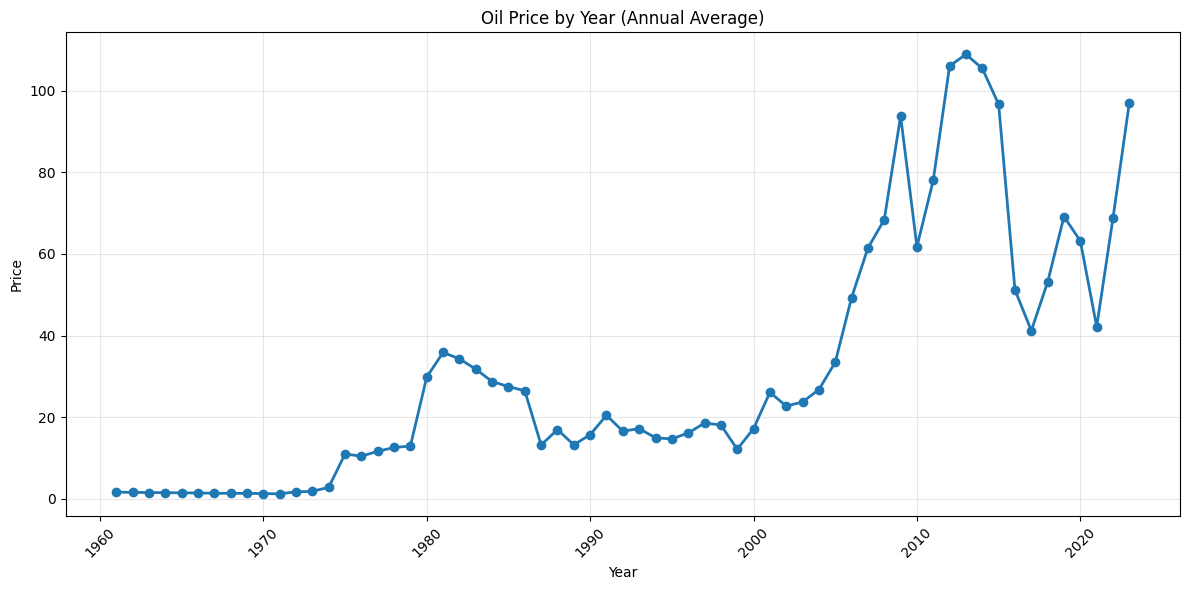

In [37]:
# Convert date column to datetime
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Resample by year and take the mean
df_oil_yearly = df_oil.set_index('date').resample('Y').mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(df_oil_yearly['date'], df_oil_yearly['oil_dubai'], marker='o', linewidth=2, markersize=6)
plt.title('Oil Price by Year (Annual Average)')
plt.xlabel('Year')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### This clearly shows that the data is not stationary, but just to verify, let us perform the ADF Test

In [50]:
adf_results =sm.tsa.stattools.adfuller(
    df_oil_yearly['oil_dubai'],
    maxlag=10,
    regression='ct',
    autolag='AIC',
    store=False,
    regresults=False
    )


# adfuller returns 5 values:
# 1. The test statistic
# 2. The p-value
# 3. The number of lags used
# 4. The number of observations used for the ADF regression and the critical values for the test statistic.


adf_results



(np.float64(-0.403467834831896),
 np.float64(0.986774256008106),
 9,
 53,
 {'1%': np.float64(-4.140604648065181),
  '5%': np.float64(-3.4968493140646304),
  '10%': np.float64(-3.177382525507634)},
 np.float64(410.85236610817844))

#### Since we compare the t-statistic (1.34), with all the critical values, we find that it is significantly larger than all of them, meaning we fail to reject H0, proving that the data is non-stationary! (Not to mention the extremely large p-val)

In [ ]:
df_oil_yearly['oil_dubai_returns'] = np.log(df_oil_yearly['oil_dubai'] / df_oil_yearly['oil_dubai'].shift(1))

df_oil_yearly['oil_dubai_returns'] = df_oil_yearly['oil_dubai_returns'].fillna(0)

df_oil_yearly['oil_dubai_returns'].head()




0    0.000000
1   -0.037504
2   -0.032365
3   -0.013245
4   -0.033902
Name: oil_dubai_returns, dtype: float64

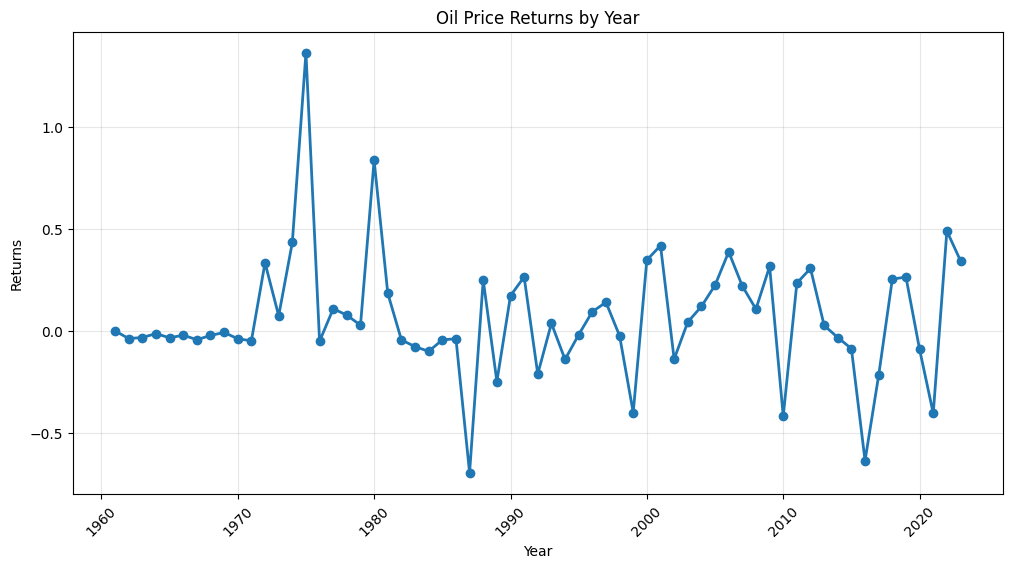

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(df_oil_yearly['date'], df_oil_yearly['oil_dubai_returns'], marker='o', linewidth=2, markersize=6)
plt.title('Oil Price Returns by Year')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()

##### You can clearly see that this data is more stationary, lets test it with the ADF test

In [49]:
t_val_returns = sm.tsa.stattools.adfuller(
    df_oil_yearly['oil_dubai_returns'],
    maxlag=10,
    regression='c',
    autolag='AIC',
    store=False,
    regresults=False
    )

t_val_returns


(np.float64(-7.043773438863908),
 np.float64(5.756623004839083e-10),
 0,
 62,
 {'1%': np.float64(-3.540522678829176),
  '5%': np.float64(-2.9094272025108254),
  '10%': np.float64(-2.5923136524453696)},
 np.float64(36.08361005276468))

##### Since the t-statistic is much lower than the critical values, we reject H0, and therefore the data is stationary,  with a very low p-val to support

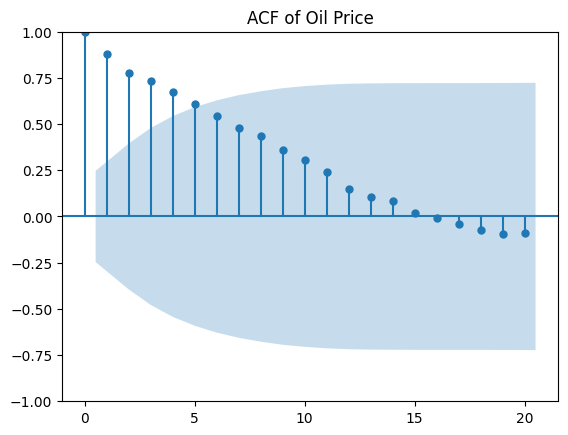

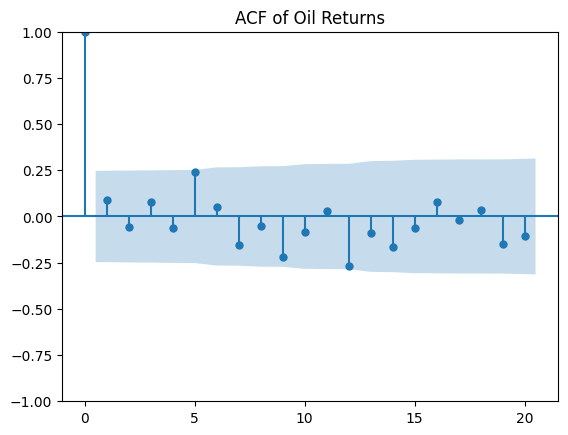

In [63]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_oil_yearly['oil_dubai'], lags=20, fft=True, alpha=0.05)
plt.title("ACF of Oil Price")
plt.show()

plot_acf(df_oil_yearly['oil_dubai_returns'], lags=20, fft=True, alpha=0.05)
plt.title("ACF of Oil Returns")
plt.show()

##### We only look at the returns (since its stationary), and we realize that there is no significant correlation that exceeds the confidence interval, we can set the MA to 1

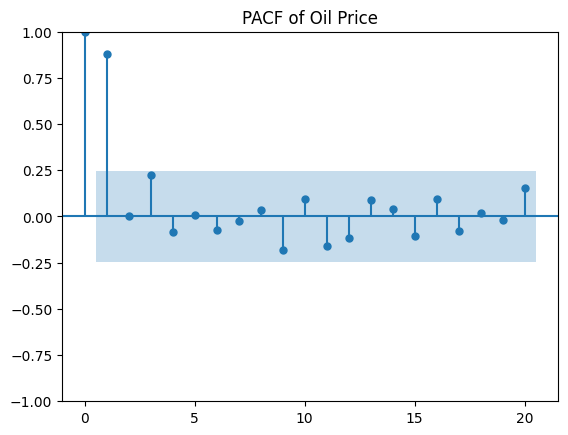

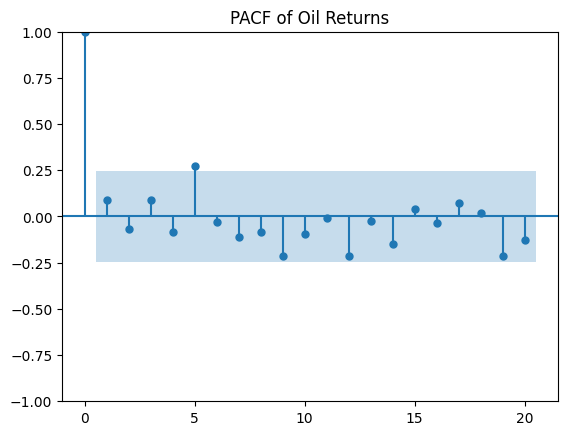

In [61]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(
df_oil_yearly['oil_dubai'],
lags=20,
alpha=0.05)
plt.title("PACF of Oil Price")
plt.show()

plot_pacf(
df_oil_yearly['oil_dubai_returns'], 
lags=20,
alpha=0.05
 )
plt.title("PACF of Oil Returns")
plt.show()

##### We only look at the returns (since its stationary), and we realize that there is no significant correlation that exceeds the confidence interval (besides 5), we can set the AR to 1 or 5!